# 3. Feature Engineering
## Create Technical Indicators and Derived Features

This notebook creates:
- EMA indicators (5 and 15 period)
- Options Greeks (Delta, Gamma, Theta, Vega, Rho)
- Derived features (IV metrics, PCR, Futures Basis, etc.)

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_utils import load_data
from features import EMAIndicators, DerivedFeatures, TimeBasedFeatures, LagFeatures, create_feature_set
from greeks import GreeksCalculator
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Matplotlib is building the font cache; this may take a moment.


Libraries imported successfully!


In [2]:
# Load merged data
df = load_data('../data/nifty_merged_5min.csv')
print(f"Data shape: {df.shape}")
df.head()

INFO:data_utils:Loading data from ../data/nifty_merged_5min.csv


Data shape: (245, 16)


,timestamp,open_spot,high_spot,low_spot,close_spot,volume_spot,open_futures,high_futures,low_futures,close_futures,volume_futures,open,high,low,close,volume
0,2025-01-20,23344.750000,23391.099609,23170.650391,23290.400391,301500,49350.800781,49650.601562,48683.601562,48834.148438,173100,1761.179077,1775.407887,1741.608239,1770.551605,4333011
1,2025-01-21,23024.650391,23426.300781,22976.849609,23421.650391,312900,48570.898438,49543.148438,48430.949219,49532.000000,134700,1748.941162,1779.001616,1741.511146,1766.763810,7169109
2,2025-01-22,23155.349609,23169.550781,22981.300781,23099.150391,276000,48724.398438,48781.750000,48074.050781,48689.550781,151700,1803.088745,1812.170087,1753.263367,1755.448694,8373913
3,2025-01-23,23205.349609,23270.800781,23090.650391,23128.300781,275600,48589.000000,48892.699219,48493.000000,48770.148438,124600,1811.829956,1825.524764,1799.446439,1804.594144,5907471
4,2025-01-24,23092.199219,23347.300781,23050.000000,23183.900391,264300,48367.800781,48858.648438,48203.000000,48546.050781,139900,1821.542603,1840.433609,1810.664579,1811.878650,4887027


## 3.1 Add EMA Indicators

In [3]:
# Calculate EMAs
df = EMAIndicators.add_ema_indicators(df, fast_period=5, slow_period=15)

print("EMA indicators added:")
print(df[['close_spot', 'ema_5', 'ema_15', 'ema_diff', 'ema_signal']].head(20))

INFO:features:Calculating EMA-5 on close
INFO:features:Calculating EMA-15 on close
INFO:features:Added EMA indicators: EMA-5, EMA-15


EMA indicators added:
      close_spot        ema_5       ema_15   ema_diff  ema_signal
0   23290.400391  1770.551605  1770.551605   0.000000          -1
1   23421.650391  1769.289007  1770.078131  -0.789124          -1
2   23099.150391  1764.675569  1768.249451  -3.573882          -1
3   23128.300781  1777.981761  1772.792538   5.189223           1
4   23183.900391  1789.280724  1777.678302  11.602422           1
5   22940.150391  1791.390486  1779.919766  11.470721           1
6   22960.449219  1786.726679  1779.604678   7.122001           1
7   23026.750000  1788.473740  1781.150076   7.323664           1
8   23169.500000  1798.752098  1785.919918  12.832180           1
9   23296.750000  1804.908264  1789.832503  15.075761           1
10  23319.349609  1797.681042  1789.006765   8.674277           1
11  23509.900391  1810.021761  1794.718819  15.302942           1
12  23801.750000  1823.752690  1801.780785  21.971905           1
13  23761.949219  1836.467903  1809.295478  27.172425 

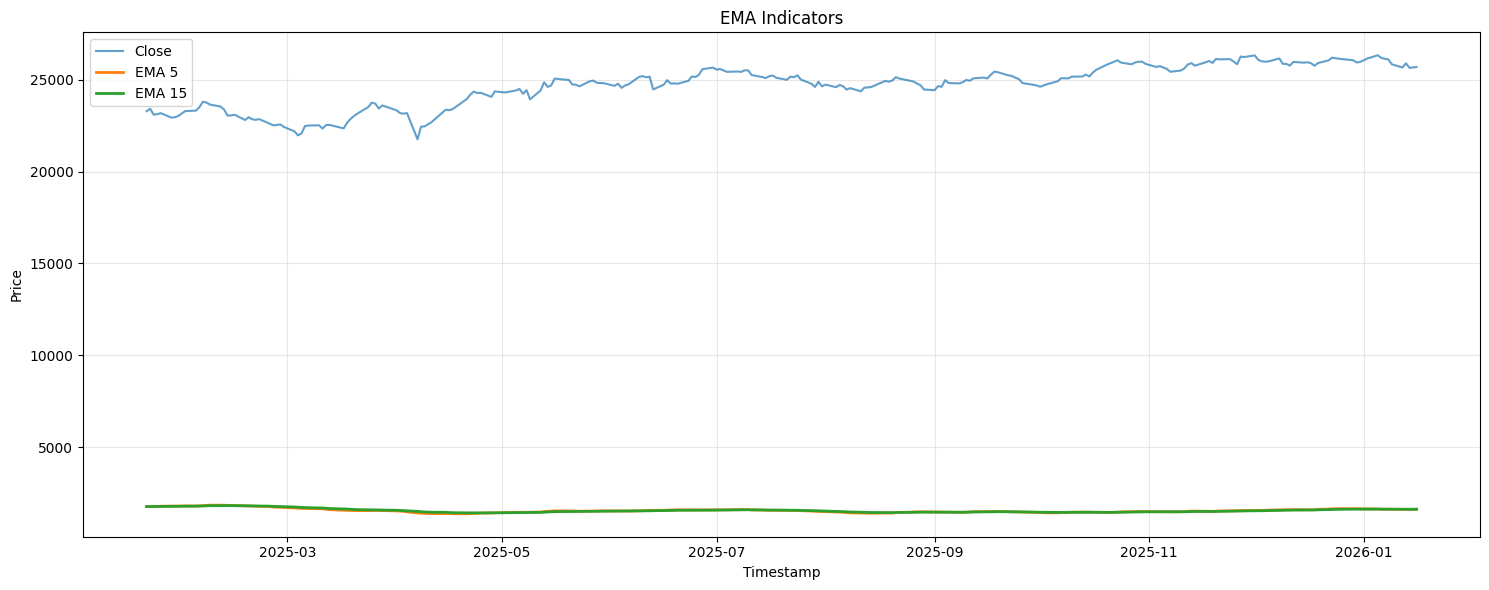

In [4]:
# Visualize EMAs
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'][:500], df['close_spot'][:500], label='Close', alpha=0.7)
plt.plot(df['timestamp'][:500], df['ema_5'][:500], label='EMA 5', linewidth=2)
plt.plot(df['timestamp'][:500], df['ema_15'][:500], label='EMA 15', linewidth=2)
plt.title('EMA Indicators')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/ema_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.2 Calculate Greeks

In [5]:
# Initialize Greeks calculator
greeks_calc = GreeksCalculator(risk_free_rate=0.065)

# Calculate Greeks for ATM Call
if 'call_iv' in df.columns:
    df = greeks_calc.add_greeks_to_dataframe(
        df,
        spot_col='close_spot',
        strike_col='atm_strike',
        iv_col='call_iv',
        option_type='call'
    )
    print("Call Greeks calculated")

# Calculate Greeks for ATM Put
if 'put_iv' in df.columns:
    df = greeks_calc.add_greeks_to_dataframe(
        df,
        spot_col='close_spot',
        strike_col='atm_strike',
        iv_col='put_iv',
        option_type='put'
    )
    print("Put Greeks calculated")

print("\nGreeks columns:")
greek_cols = [col for col in df.columns if any(g in col for g in ['delta', 'gamma', 'theta', 'vega', 'rho'])]
print(greek_cols)

INFO:greeks:Initialized Black-Scholes Greeks calculator with r=0.065



Greeks columns:
[]


## 3.3 Add Derived Features

In [ ]:
# Add all derived features
df = DerivedFeatures.add_all_derived_features(df)

print("Derived features added:")
derived_cols = ['avg_iv', 'iv_spread', 'pcr_oi', 'pcr_volume', 'futures_basis', 
                'spot_returns', 'delta_neutral_ratio', 'gamma_exposure']
for col in derived_cols:
    if col in df.columns:
        print(f"  ✓ {col}")

## 3.4 Add Time-Based Features

In [ ]:
# Add time features
df = TimeBasedFeatures.add_time_features(df, timestamp_col='timestamp')

print("Time-based features added:")
time_cols = ['hour', 'minute', 'day_of_week', 'is_opening_hour', 'is_closing_hour']
print(df[time_cols].head())

## 3.5 Add Lag Features

In [ ]:
# Add lag features for key columns
key_columns = ['close_spot', 'volume_spot', 'avg_iv', 'pcr_oi']
key_columns = [col for col in key_columns if col in df.columns]

df = LagFeatures.add_lag_features(df, columns=key_columns, lags=[1, 2, 3])

print(f"\nLag features added for {len(key_columns)} columns")

## 3.6 Feature Statistics

In [ ]:
# Display feature statistics
print("Feature Statistics:")
print(df.describe())

In [ ]:
# Correlation heatmap
feature_cols = ['ema_5', 'ema_15', 'avg_iv', 'iv_spread', 'pcr_oi', 'futures_basis', 'spot_returns']
feature_cols = [col for col in feature_cols if col in df.columns]

plt.figure(figsize=(12, 10))
correlation_matrix = df[feature_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('../plots/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

## 3.7 Save Feature Set

In [ ]:
# Save complete feature set
df.to_csv('../data/nifty_features_5min.csv', index=False)
print(f"\nFeature set saved: {df.shape[0]} rows, {df.shape[1]} columns")
print("File: data/nifty_features_5min.csv")

## Summary

In [6]:
print("=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)
print(f"\nTotal features: {df.shape[1]}")
print(f"Total rows: {df.shape[0]}")
print("\nFeature categories:")
print("  ✓ EMA Indicators (5, 15 period)")
print("  ✓ Options Greeks (Delta, Gamma, Theta, Vega, Rho)")
print("  ✓ Derived Features (IV, PCR, Basis, Returns)")
print("  ✓ Time-based Features")
print("  ✓ Lag Features")
print("\nNext Step: Proceed to 04_regime_detection.ipynb")

FEATURE ENGINEERING SUMMARY

Total features: 20
Total rows: 245

Feature categories:
  ✓ EMA Indicators (5, 15 period)
  ✓ Options Greeks (Delta, Gamma, Theta, Vega, Rho)
  ✓ Derived Features (IV, PCR, Basis, Returns)
  ✓ Time-based Features
  ✓ Lag Features

Next Step: Proceed to 04_regime_detection.ipynb
